# Visualization of waveplate transformations
A pedagogical introduction to polarization optics. 

I borrowed heavily from "A polarization gadget with two quarter wave plates: Application to Mueller Polarimetry" (2021) https://browse.arxiv.org/pdf/1412.7805.pdf. A fantastic application of the method of two loci.

## Purpose
The full set of polarization operations can be mapped to SU(2), a group that can only be fully expressed with at least 3 generators. So it intuitively makes sense that a QWP + HWP + QWP will perform complete polarization control (https://en.wikipedia.org/wiki/Polarization_controller).

However, a pair of initial and final states is connected by more than one operator from SU(2). So it is possible that an appropriate subset of SU(2) can be used for arbitrary polarization control. As a frugal experimentalist, this leads to asking, can we accomplish the same with less? (This is also good for experimental stability.)

This notebook was written with several questions in mind:
- Is it possible to perform arbitary polarization control with a HWP + QWP?
- Is a QWP + QWP sufficient?
- Is it possible to transform an arbitrary linear polarization to an arbitrary one with a HWP + QWP? Does the order of the waveplates matter?
- How can I intuitively think about waveplate errors, e.g., due to manufacturing or misalignment?

Answers:
- No.
- Yes.
- Probably? A gut feeling based on some playing with the visualizations below.
- See below.

In [1]:
import qutip
import numpy as np
%matplotlib notebook

# Basic functions for Jones calculus
See https://en.wikipedia.org/wiki/Jones_calculus.

Qutip Qobj's are used for visualization on the Poincare sphere. However, I deviate from the usual convention of RCP and LCP on the poles. Instead, the poles correspond to vertical and horizontal polarization.

The implementation here is a bit sloppy, in that I go back and forth between Qobjects and numpy arrays.

In [6]:
def get_wp_matrix(theta, eta):
    """
    Return the transformation matrix for a general waveplate a.k.a. linear phase retarder. 
    
    Args
    - theta: fast axis angle, relative to horizontal polarization. [rad]
    - eta: phase retardance between slow and fast axes, e.g. pi for HWP. [rad]
    """
    return np.exp(- 1j * eta / 2) * np.array([[np.cos(theta)**2 + np.exp(1j * eta) * np.sin(theta)**2, (1 - np.exp(1j * eta)) * np.sin(theta) * np.cos(theta)],
                           [(1 - np.exp(1j * eta)) * np.sin(theta) * np.cos(theta), np.sin(theta) ** 2 + np.exp(1j * eta) * np.cos(theta) ** 2]])

def get_state(mixing, delay):
    """
    Returns a state vector represented as both a numpy array and a qutip Qobj.
    
    Args
    - mixing: mixing angle between horizontal and vertical polarizations, e.g. pi/2 for horizontal, pi/4 for equal superposition.
    - delay: relative phase between horizontal and vertical polarization.
    """
    state_vec = np.array([np.cos(mixing), np.sin(mixing) * np.exp(1j * delay)]).T
    q_state = qutip.basis(2,0) * state_vec[0] + qutip.basis(2,1) * state_vec[1]
    return state_vec, q_state

def get_locus(initial_state, wp_matrices):
    """
    Returns a list of states (Qobj) that can be reached starting from initial_state (numpy array) and the list of wp_matrices.
    
    Intended usage: generate a list of wp_matrices for fixed eta and theta in [0,2pi] to represent the possible transformations a given waveplate can perform.
    """
    final_state_vecs = []
    for wp_matrix in wp_matrices:
        final_state_vec = wp_matrix.dot(initial_state)
        final_state_vecs.append(qutip.basis(2,0) * final_state_vec[0] + qutip.basis(2,1) * final_state_vec[1])
    return final_state_vecs
        
def draw_locus(final_state_vecs, my_bloch=None):
    """
    Draw the locus generated by get_locus(...) on a qutip.Bloch sphere, for visualization.
    """
    if my_bloch is None:
        my_bloch = qutip.Bloch()
        
    final_state_points = []
    for st in final_state_vecs:
        vec = np.array([qutip.expect(qutip.sigmax(), st),
               qutip.expect(qutip.sigmay(), st),
               qutip.expect(qutip.sigmaz(), st)])
        final_state_points.append(vec)
    my_bloch.add_points(np.array(final_state_points).T, meth='l')
    
def demo(mixing, delay, eta):
    """
    Visualize possible actions of a general waveplate with retardance eta, starting from an initial state with parameters mixing and delay (see get_state(...)). 
    """
    initial_state_arr, initial_state_q = get_state(mixing, delay)

    # generate possible transformations of a perfect HWP
    thetas = np.linspace(0,2*np.pi, 100)
    wp_matrices = [get_wp_matrix(theta, eta) for theta in thetas]

    # get locus of possible final states
    final_state_vecs = get_locus(initial_state_arr, wp_matrices)

    # visualize
    b = qutip.Bloch()
    b.add_states(initial_state_q)
    draw_locus(final_state_vecs, my_bloch=b)
    b.show()
    
def demo_paper(mixing1, delay1, eta1, mixing2, delay2, eta2):
    """
    
    """
    b = qutip.Bloch()
    
    def helper(mixing, delay, eta):
        initial_state_arr, initial_state_q = get_state(mixing, delay)

        # generate possible transformations of a perfect HWP
        thetas = np.linspace(0,2*np.pi, 100)
        wp_matrices = [get_wp_matrix(theta, eta) for theta in thetas]

        # get locus of possible final states
        final_state_vecs = get_locus(initial_state_arr, wp_matrices)
        
        # visualize
        b.add_states(initial_state_q)
        draw_locus(final_state_vecs, my_bloch=b)

    helper(mixing1, delay1, eta1)
    helper(mixing2, delay2, eta2)
    
    b.show()

# Example with linear polarized light and HWP
Initial state of horizontal polarization is shown by the green vector below. The blue curve indicates the set of possible final states attainable with a HWP. For this case, it is the set of all possible linear polarizations.

The blue curve denotes the boundary between right and left hand elliptical states, between the East and West hemispheres.

<IPython.core.display.Javascript object>


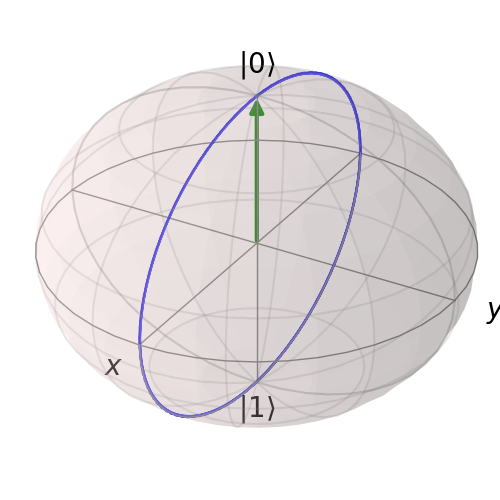

In [5]:
mixing, delay, retardance = 0, 0, np.pi
demo(mixing, delay, retardance)

# Example with horizontal linear polarized light and QWP
Initial state of horizontal polarization is shown by the green vector below. The blue curve indicates the set of possible final states attainable with a QWP. A variety of elliptical polarizations and the two perfect circular polarizations ($\pm \hat{y}$) are produced. 

<IPython.core.display.Javascript object>


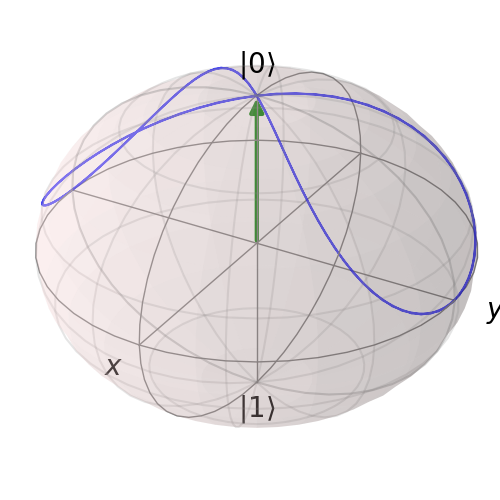

In [30]:
mixing, delay, retardance = np.pi * 0 / 180, 0, np.pi/2
demo(mixing, delay, retardance)

# Example with non-horizontal linear polarized light and QWP
Notice that the blue curve touches the initial state vector for both the above and below example. This is because the initial state (linear polarization) is an eigenvector of the QWP transformation when the polarization is aligned with either the fast or slow axis.

<IPython.core.display.Javascript object>


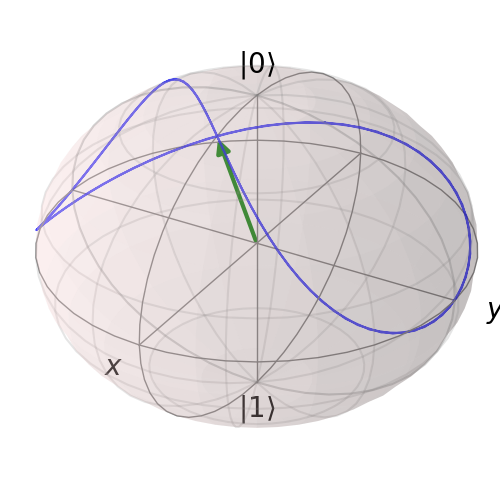

In [32]:
mixing, delay, retardance = np.pi * 10 / 180, 0, np.pi/2
demo(mixing, delay, retardance)

# Example with elliptical polarized light and QWP
A couple interesting things happen here:
- the dumbbell becomes asymmetric
- it is impossible to create perfect circular polarization
- the initial state no longer touches the blue curve. That is, a QWP can never leave elliptical light untouched!

<IPython.core.display.Javascript object>


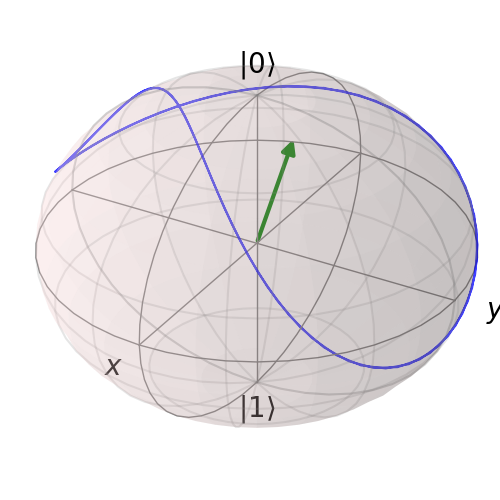

In [34]:
mixing, delay, retardance = np.pi * 10 / 180, 45, np.pi/2
demo(mixing, delay, retardance)

# Example with elliptical polarized light and HWP
A couple interesting things happen here:
- the handedness becomes inverted
- the initial state no longer touches the blue curve. That is, a HWP can never leave elliptical light untouched either!

<IPython.core.display.Javascript object>


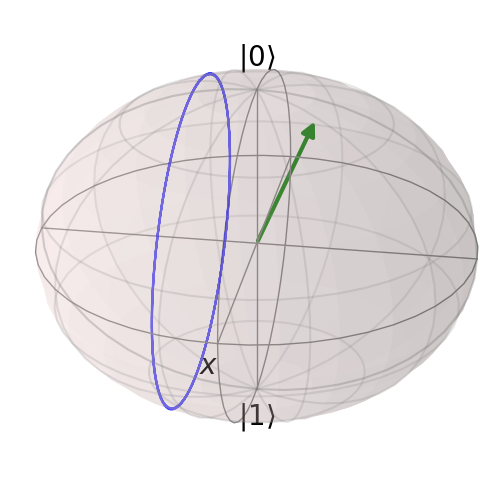

In [38]:
mixing, delay, retardance = np.pi * 10 / 180, 45, np.pi
demo(mixing, delay, retardance)

# Anything is possible! (with two QWPs)
The big idea of this paper "A polarization gadget with two quarter wave plates: Application to Mueller Polarimetry" (2021) https://browse.arxiv.org/pdf/1412.7805.pdf is stated above.

Their proof uses a basic idea from high school geometry, the intersection of two loci. Above, we have visualized the possible transformations a waveplate can perform on certain initial states using a single locus. To see whether or not a final state can be reached with an second waveplate, we examine whether the locus of states generated by the *inverse* transformation of the second waveplate on the final state intersects with the first locus. If such an intersection exists, there exists a waveplate setting for reaching the final state.

The visualizations in this notebook are heavily inspired by the paper's figures.

Let's see a few examples of their claim.

<IPython.core.display.Javascript object>


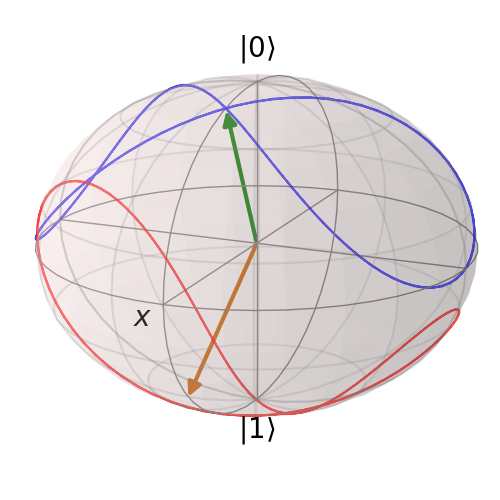

In [16]:
demo_paper(
    np.pi * 10 / 180, 0, np.pi/2, # linear, QWP
    np.pi * 80 / 180, -45 * np.pi / 180, -np.pi/2 # elliptical, QWP
          )

<IPython.core.display.Javascript object>


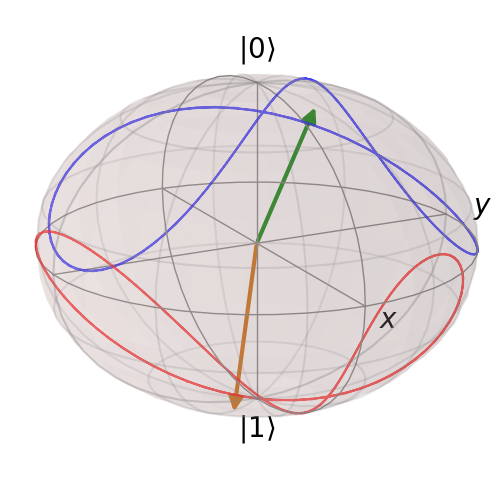

In [17]:
demo_paper(
    np.pi * 10 / 180, 22.5 * np.pi / 180, np.pi/2, # elliptical, QWP
    np.pi * 80 / 180, -45 * np.pi / 180, -np.pi/2 # some other elliptical, QWP
          )

# Typical lab practice (start from linear, use HWP + QWP)
It seems to be possible to go from any linear to any arbitrary polarization using this combo, regardless of the order.

In the lab, we typically use light that is linearly polarized from a polarizing beam splitter before inserting to a polarization sensitive component (such as the birefringent connector of a fiber), or conversely, want to fully transmit light of unknown polarization through a polarizer.

<IPython.core.display.Javascript object>


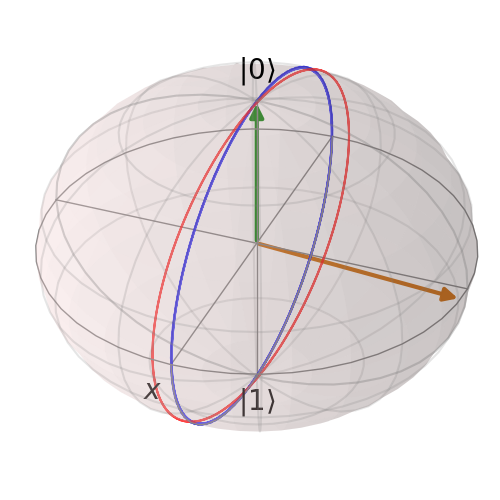

In [47]:
demo_paper(
    np.pi * 0 / 180, 0 * np.pi / 180, np.pi, # linear, HWP
    np.pi * 45 / 180, 85 * np.pi / 180, -np.pi/2  # elliptical, QWP
          )

<IPython.core.display.Javascript object>


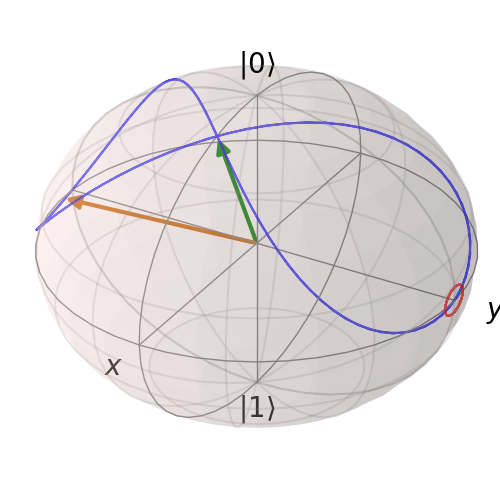

In [49]:
demo_paper(
    np.pi * 10 / 180, 0 * np.pi / 180, np.pi/2, # linear, QWP
    np.pi * 45 / 180, -85 * np.pi / 180, -np.pi # elliptical, HWP
          )

<IPython.core.display.Javascript object>


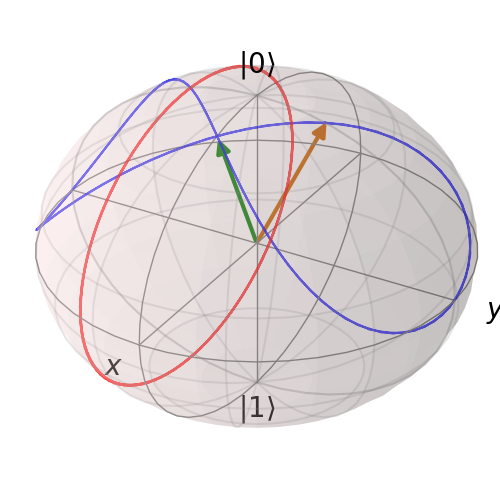

In [50]:
demo_paper(
    np.pi * 10 / 180, 0 * np.pi / 180, np.pi/2, # linear, QWP
    np.pi * -10 / 180, -85 * np.pi / 180, -np.pi # elliptical, HWP
          )

# Limitations of HWP + QWP
It is definitely possible to find pairs of states not connected by HWP + QWP (in either order), i.e. there is no intersection. So this is not as versatile as a QWP + QWP.

<IPython.core.display.Javascript object>


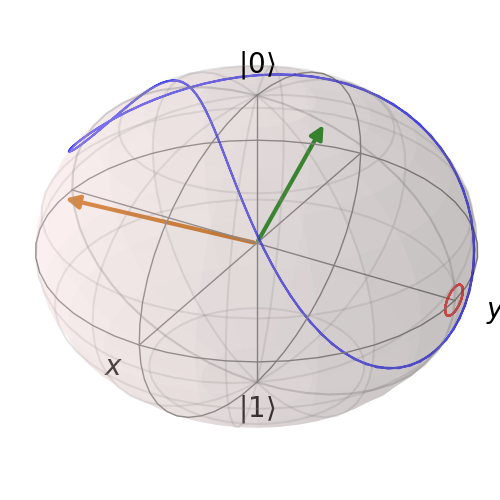

In [51]:
demo_paper(
    np.pi * 10 / 180, 90 * np.pi / 180, np.pi/2, # elliptical, QWP
    np.pi * 45 / 180, -85 * np.pi / 180, -np.pi # elliptical, HWP
          )

<IPython.core.display.Javascript object>


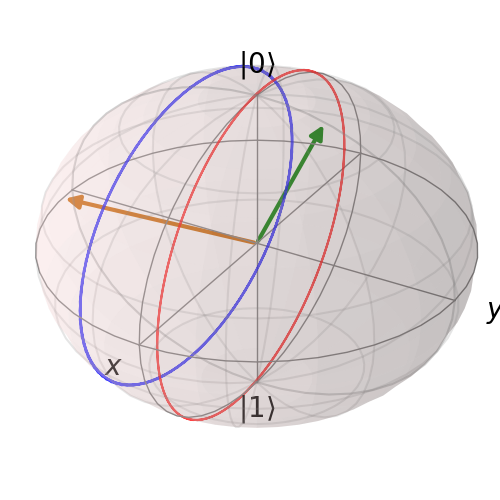

In [54]:
demo_paper(
    np.pi * 10 / 180, 90 * np.pi / 180, np.pi, # elliptical, HWP
    np.pi * 45 / 180, -85 * np.pi / 180, -np.pi/2 # elliptical, QWP
          )

# Waveplate error
5% is an exaggeration, typically an egregious use in the lab would be to use 780nm waveplates for 767nm lasers, which is +1.6%.

Cosine error due to misalignment could also be a cause of negative errors.

For QWPs, it makes the dumbbell bigger with positive error.
For HWPs, it makes the loci non-circular.

<IPython.core.display.Javascript object>


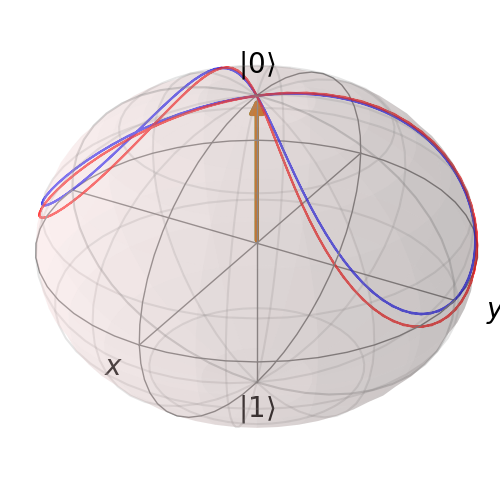

In [61]:
error = 0.05
demo_paper(
    np.pi * 0 / 180, 0 * np.pi / 180, np.pi/2, # linear, perfect QWP
    np.pi * 0 / 180, 0 * np.pi / 180, -np.pi/2 * (1 + error) # linear, imperfect QWP
          )

<IPython.core.display.Javascript object>


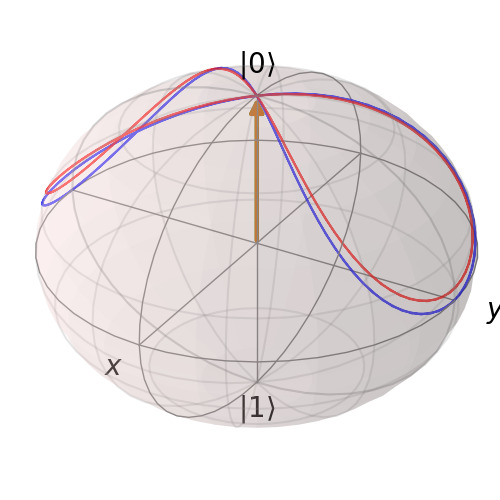

In [62]:
error = -0.05
demo_paper(
    np.pi * 0 / 180, 0 * np.pi / 180, np.pi/2, # linear, perfect QWP
    np.pi * 0 / 180, 0 * np.pi / 180, -np.pi/2 * (1 + error) # linear, imperfect QWP
          )

<IPython.core.display.Javascript object>


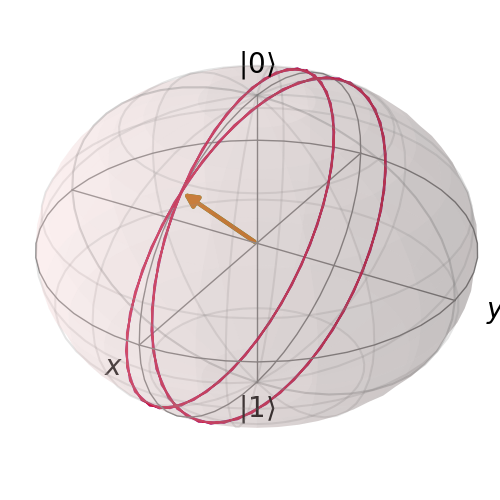

In [66]:
error = -0.05
demo_paper(
    np.pi * 20 / 180, 0 * np.pi / 180, np.pi * (1 - error), # linear, HWP
    np.pi * 20 / 180, 0 * np.pi / 180, -np.pi * (1 + error) # linear, HWP
          )

<IPython.core.display.Javascript object>


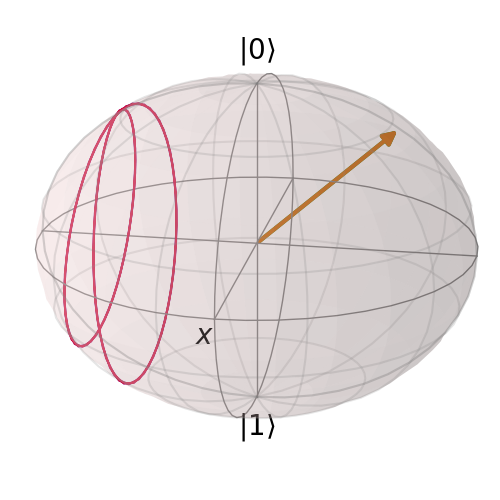

In [68]:
error = -0.05
demo_paper(
    np.pi * 20 / 180, 90 * np.pi / 180, np.pi * (1 - error), # linear, HWP
    np.pi * 20 / 180, 90 * np.pi / 180, -np.pi * (1 + error) # linear, HWP
          )